In [1]:
import matplotlib.image as mpimg
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from PIL import Image

In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
import os

In [4]:
trdata=[]
for info in os.listdir('C:\\Users\\User\\Desktop\\images\\train_r'):
    domain = os.path.abspath('C:\\Users\\User\\Desktop\\images\\train_r')
    info = os.path.join(domain,info)
    pil_im = Image.open(info)
    pil_im = pil_im.resize((224,224))
    pil_im = np.array(pil_im)/255.0
    pil_im = pil_im[:,:,0]*0.299+pil_im[:,:,1]*0.587+pil_im[:,:,2]*0.114
    pil_im = np.reshape(pil_im,(-1,224,224,1))
    pil_im = pil_im.astype('float32')
    trdata.append(pil_im)
trdata=np.array(trdata)

In [5]:
ytdata=[]
for info in os.listdir('C:\\Users\\User\\Desktop\\images\\train_3.4.3'):
    domain = os.path.abspath('C:\\Users\\User\\Desktop\\images\\train_3.4.3')
    info = os.path.join(domain,info)
    pil_im = Image.open(info)
    pil_im = pil_im.resize((224,224))
    pil_im = np.array(pil_im)/255.0
    pil_im = pil_im[:,:,0]*0.299+pil_im[:,:,1]*0.587+pil_im[:,:,2]*0.114
    pil_im = np.reshape(pil_im,(-1,224,224,1))
    pil_im = pil_im.astype('float32')
    ytdata.append(pil_im)
ytdata=np.array(ytdata)

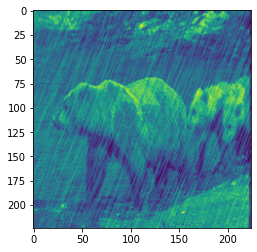

In [6]:
plt.imshow(np.squeeze(trdata[0]))

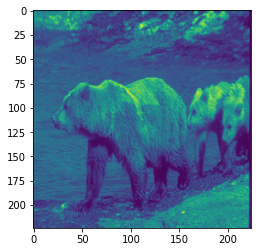

In [7]:
plt.imshow(np.squeeze(ytdata[0]))

In [32]:
#224*224*300=15052800
from tensorflow import keras
from tensorflow.keras import layers
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (4, 4),activation='relu',padding='same', input_shape=(224, 224, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (4, 4),padding='same',activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(256, (4, 4),padding='same',activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(512, (4, 4),strides=(1, 1),padding='same',activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(1, (4, 4),strides=(1, 1),padding='same',activation='relu'))#(64*4*4)+(128*4*4)+(256*4*4)+(512*4*4)+(4*4)=15376
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(50176, activation='relu'))
    model.add(layers.Reshape((224,224,1)))
    return model

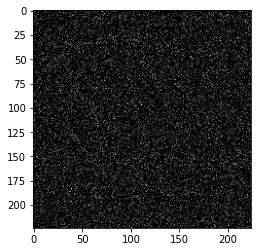

In [33]:
generator = make_generator_model()

generated_image = generator(trdata[0], training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [34]:
generated_image.shape

TensorShape([1, 224, 224, 1])

In [35]:
generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 224, 224, 64)      1088      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 112, 112, 128)     131200    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 56, 56, 256)       524544    
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 28, 28, 256)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 28, 28, 512)      

In [36]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [37]:
def generator_loss(fake_output,real):
    real=tf.convert_to_tensor(real)
    return (tf.norm((fake_output-real),ord='fro',axis=(0,1)))**2

In [38]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (3, 3), padding='same',
                                     input_shape=[224, 224, 1]))
    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(512, (3, 3), padding='same'))
    model.add(layers.Conv2D(512, (3, 3), padding='same'))
    model.add(layers.Conv2D(512, (3, 3), padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(512, (3, 3), padding='same'))
    model.add(layers.Conv2D(512, (3, 3), padding='same'))
    model.add(layers.Conv2D(512, (3, 3), padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    return model

In [39]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-8.6178386e-07]], shape=(1, 1), dtype=float32)


In [40]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [41]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [42]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [43]:
EPOCHS = 500

In [44]:
@tf.function
def train_step(images,yi):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(images, training=True)

      #real_output = discriminator(yi, training=True)
      #fake_output = discriminator(generated_images, training=True)
      gen_loss = generator_loss(generated_images,yi)
      #gen_loss = generator_loss(fake_output,yi)
      #disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    #gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    #discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [45]:
import time
def train(trdataset,ydataset ,epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch,yi in zip(trdataset,ydataset):
      train_step(image_batch,yi)

    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))


In [46]:
train(trdata,ytdata,EPOCHS)

Time for epoch 1 is 2.7727794647216797 sec
Time for epoch 2 is 1.9652073383331299 sec
Time for epoch 3 is 1.973656177520752 sec
Time for epoch 4 is 1.9767718315124512 sec
Time for epoch 5 is 1.9777629375457764 sec
Time for epoch 6 is 1.98775053024292 sec
Time for epoch 7 is 1.986644983291626 sec
Time for epoch 8 is 1.9837985038757324 sec
Time for epoch 9 is 1.9830012321472168 sec
Time for epoch 10 is 1.9884350299835205 sec
Time for epoch 11 is 1.9854774475097656 sec
Time for epoch 12 is 1.9849953651428223 sec
Time for epoch 13 is 1.9887797832489014 sec
Time for epoch 14 is 1.9906415939331055 sec
Time for epoch 15 is 3.3385889530181885 sec
Time for epoch 16 is 2.019503593444824 sec
Time for epoch 17 is 1.993570327758789 sec
Time for epoch 18 is 1.9947545528411865 sec
Time for epoch 19 is 1.9925611019134521 sec
Time for epoch 20 is 1.9976739883422852 sec
Time for epoch 21 is 1.9877574443817139 sec
Time for epoch 22 is 1.993687391281128 sec
Time for epoch 23 is 1.9906249046325684 sec
Time

Time for epoch 188 is 2.0074126720428467 sec
Time for epoch 189 is 2.007606029510498 sec
Time for epoch 190 is 2.0065548419952393 sec
Time for epoch 191 is 2.0006046295166016 sec
Time for epoch 192 is 2.00456166267395 sec
Time for epoch 193 is 2.0056650638580322 sec
Time for epoch 194 is 1.9996428489685059 sec
Time for epoch 195 is 3.454882860183716 sec
Time for epoch 196 is 2.0429346561431885 sec
Time for epoch 197 is 2.002777099609375 sec
Time for epoch 198 is 1.9986815452575684 sec
Time for epoch 199 is 1.9976778030395508 sec
Time for epoch 200 is 1.999756097793579 sec
Time for epoch 201 is 2.005575180053711 sec
Time for epoch 202 is 2.0064172744750977 sec
Time for epoch 203 is 1.99668288230896 sec
Time for epoch 204 is 2.0017426013946533 sec
Time for epoch 205 is 2.001613140106201 sec
Time for epoch 206 is 2.0004196166992188 sec
Time for epoch 207 is 2.0036611557006836 sec
Time for epoch 208 is 1.9997928142547607 sec
Time for epoch 209 is 2.001406669616699 sec
Time for epoch 210 is

Time for epoch 372 is 1.9985973834991455 sec
Time for epoch 373 is 1.994701862335205 sec
Time for epoch 374 is 1.9975836277008057 sec
Time for epoch 375 is 3.4717795848846436 sec
Time for epoch 376 is 2.0262346267700195 sec
Time for epoch 377 is 2.0015432834625244 sec
Time for epoch 378 is 1.9927597045898438 sec
Time for epoch 379 is 1.9946374893188477 sec
Time for epoch 380 is 2.000610828399658 sec
Time for epoch 381 is 1.996680736541748 sec
Time for epoch 382 is 1.9945244789123535 sec
Time for epoch 383 is 1.9941742420196533 sec
Time for epoch 384 is 1.9951882362365723 sec
Time for epoch 385 is 1.9966318607330322 sec
Time for epoch 386 is 1.995906114578247 sec
Time for epoch 387 is 1.9934945106506348 sec
Time for epoch 388 is 1.998511791229248 sec
Time for epoch 389 is 2.0006155967712402 sec
Time for epoch 390 is 3.397641897201538 sec
Time for epoch 391 is 2.0229849815368652 sec
Time for epoch 392 is 1.9940886497497559 sec
Time for epoch 393 is 1.9932880401611328 sec
Time for epoch 3

In [84]:
genee = generator(trdata[30], training=False)

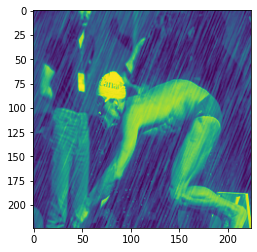

In [85]:
plt.imshow(np.squeeze(trdata[30]))

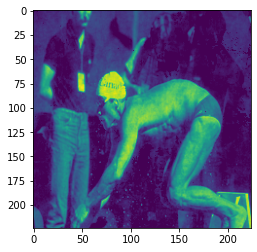

In [86]:
genee=np.squeeze(genee)
plt.imshow(genee)